#### **RQ1** - Part 1
- RQ1a: Do concept-based interventions reduce cheating behavior?
- RQ1b: Do the effects on cheating vary by concepts?


This is the first part of RQ1 where we analyze the impact of concept-based interventions on cheating behavior. We use a multinomial logistic regression model to assess the effects of different interventions on the likelihood of cheating behavior, using a hyper prior for the model.

In [1]:
# =============================================================================
# 1. SETUP AND DATA PREPARATION
# =============================================================================

import sys, os, warnings
sys.path.append('../')
warnings.filterwarnings('ignore')
os.chdir('game-behavior-analytics/data_analysis_notebook/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    return 0 if rate == 0 else 2 if rate == 1 else 1

# Create analysis variables
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare categorical variables
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])

concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

# Create nested message structure: concept -> messages
message_df = df[['concept', 'motivational_message_id']].drop_duplicates()
concept_message_map = {}
for concept in concept_ids.cat.categories:
    messages = message_df[message_df['concept'] == concept]['motivational_message_id'].unique()
    concept_message_map[concept] = {msg: i for i, msg in enumerate(messages)}

# Create nested message indices
df['concept_idx'] = concept_codes
df['message_within_concept'] = df.apply(
    lambda row: concept_message_map[row['concept']][row['motivational_message_id']], axis=1
)



In [2]:
# =============================================================================
# 2. DESCRIPTIVE ANALYSIS
# =============================================================================

def calc_props_ci(data, col):
    """Calculate proportions (%), standard error, and 95% CI for each category (0,1,2)."""
    n = len(data)
    results = {}
    for cat in [0,1,2]:
        count = (data[col] == cat).sum()
        prop = count / n if n > 0 else 0
        se = np.sqrt(prop * (1 - prop) / n) if n > 0 else 0
        ci_lower = max(0, prop - 1.96 * se)
        ci_upper = min(1, prop + 1.96 * se)
        results[cat] = {
            'prop': prop * 100,
            'se': se * 100,
            'ci': f"[{round(ci_lower*100,1)}, {round(ci_upper*100,1)}]"
        }
    return results, n

# Theory groupings for concept ordering
theory_order = [
    'autonomy', 'competence', 'relatedness',
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'
]

control = df[df['concept'] == 'control']
intervention = df[df['concept'] != 'control']

# Calculate control and intervention overall
control_stats, n_control = calc_props_ci(control, 'cheating_behavior')
interv_stats, n_interv = calc_props_ci(intervention, 'cheating_behavior')

# Print Control and Intervention overall first
print("=" * 130)
print(f"{'Concept':<35} {'Non-cheater [95% CI]':<25} {'Partial [95% CI]':<25} {'Full [95% CI]':<25} {'n':<5}")
print("-" * 130)

print(f"{'Control (baseline)':<35} "
      f"{control_stats[0]['prop']:>6.1f}% {control_stats[0]['ci']:<15} "
      f"{control_stats[1]['prop']:>6.1f}% {control_stats[1]['ci']:<15} "
      f"{control_stats[2]['prop']:>6.1f}% {control_stats[2]['ci']:<15} "
      f"{n_control:<5}")

print(f"{'Intervention (overall)':<35} "
      f"{interv_stats[0]['prop']:>6.1f}% {interv_stats[0]['ci']:<15} "
      f"{interv_stats[1]['prop']:>6.1f}% {interv_stats[1]['ci']:<15} "
      f"{interv_stats[2]['prop']:>6.1f}% {interv_stats[2]['ci']:<15} "
      f"{n_interv:<5}")

# Now the header for percentage changes vs control
print("=" * 130)
print("RAW PERCENTAGE CHANGES BY CONCEPT (vs Control) WITH 95% CI OF DIFFERENCE")
print("-" * 130)
print(f"{'Concept':<35} {'Non-cheater [95% CI]':<25} {'Partial [95% CI]':<25} {'Full [95% CI]':<25} {'n':<5}")
print("-" * 130)

# Each concept vs control in theory order with difference CIs
for concept in theory_order:
    if concept in df['concept'].unique():
        subset = df[df['concept'] == concept]
        stats, n_sub = calc_props_ci(subset, 'cheating_behavior')
        
        concept_clean = concept.replace('_', ' ').title()
        row = f"{concept_clean:<35}"
        
        for cat in [0,1,2]:
            diff = stats[cat]['prop'] - control_stats[cat]['prop']
            se_diff = np.sqrt(stats[cat]['se']**2 + control_stats[cat]['se']**2)
            ci_lower = diff - 1.96 * se_diff
            ci_upper = diff + 1.96 * se_diff
            ci_str = f"[{ci_lower:.1f}, {ci_upper:.1f}]"
            row += f"{diff:+6.1f}% {ci_str:<15}"
        
        row += f"{n_sub:<5}"
        print(row)


Concept                             Non-cheater [95% CI]      Partial [95% CI]          Full [95% CI]             n    
----------------------------------------------------------------------------------------------------------------------------------
Control (baseline)                    53.4% [42.0, 64.9]      13.7% [5.8, 21.6]       32.9% [22.1, 43.7]    73   
Intervention (overall)                63.3% [60.6, 66.1]      17.5% [15.3, 19.7]      19.2% [16.9, 21.4]    1159 
RAW PERCENTAGE CHANGES BY CONCEPT (vs Control) WITH 95% CI OF DIFFERENCE
----------------------------------------------------------------------------------------------------------------------------------
Concept                             Non-cheater [95% CI]      Partial [95% CI]          Full [95% CI]             n    
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            +12.4% [-3.3, 28.0]     +6.0% 

In [3]:
# Calculate control group baselines for informative priors
control_counts = control['cheating_behavior'].value_counts().sort_index()
n_total = control_counts.sum()
n_non, n_partial, n_full = control_counts[0], control_counts[1], control_counts[2]
control_partial_logit = np.log(n_partial / n_non) if n_non > 0 else -2
se_partial = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
control_full_logit = np.log(n_full / n_non) if n_non > 0 else -1
se_full = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0

In [4]:
# =============================================================================
# 3.1. BAYESIAN MULTINOMIAL LOGISTIC REGRESSION MODEL 
# 
# USING HYPER PRIORS: Expects similar effects across conditions - shrink estimates toward common mean
# =============================================================================

print("\n" + "="*70)
print("BAYESIAN MULTINOMIAL LOGISTIC REGRESSION")
print("="*70)

with pm.Model() as cheating_model:

    # Control group intercepts (informative priors)
    beta_partial_intercept = pm.Normal('Intercept (Partial Cheating vs No Cheating)', mu=control_partial_logit, sigma=se_partial)
    
    beta_full_intercept = pm.Normal('Intercept (Full Cheating vs No Cheating)', mu=control_full_logit, sigma=se_full
    )
    
    # Hierarchical concept effects
    mu_concept_partial = pm.Normal('Mean Concept Effect (Partial Cheating)', mu=0, sigma=1)
    sigma_concept_partial = pm.HalfNormal('SD Concept Effect (Partial Cheating)', sigma=1)
    
    concept_effects_partial = pm.Normal('Concept Effects (Partial Cheating)', mu=mu_concept_partial, sigma=sigma_concept_partial, shape=len(concepts))
    
    mu_concept_full = pm.Normal('Mean Concept Effect (Full Cheating)', mu=0, sigma=1)
    sigma_concept_full = pm.HalfNormal('SD Concept Effect (Full Cheating)', sigma=1)
    
    concept_effects_full = pm.Normal('Concept Effects (Full Cheating)', mu=mu_concept_full, sigma=sigma_concept_full, shape=len(concepts))
    
    # Linear predictors
    concept_effect_partial = pm.math.switch(df['concept_idx'].values > 0, concept_effects_partial[df['concept_idx'].values - 1], 0)
    
    concept_effect_full = pm.math.switch(df['concept_idx'].values > 0, concept_effects_full[df['concept_idx'].values - 1], 0)
    
    eta_partial = beta_partial_intercept + concept_effect_partial
    eta_full = beta_full_intercept + concept_effect_full
    
    # Multinomial logistic probabilities
    logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('Observed Cheating Behavior', p=probs, observed=df['cheating_behavior'].values)


# Model fitting
print("Fitting Bayesian model...")
with cheating_model:
    trace_cheating = pm.sample(1500, tune=1000, chains=4, cores=4, target_accept=0.9, random_seed=42)
    ppc_cheating = pm.sample_posterior_predictive(trace_cheating, random_seed=42)

print("Model fitting completed.")



BAYESIAN MULTINOMIAL LOGISTIC REGRESSION
Fitting Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept (Partial Cheating vs No Cheating), Intercept (Full Cheating vs No Cheating), Mean Concept Effect (Partial Cheating), SD Concept Effect (Partial Cheating), Concept Effects (Partial Cheating), Mean Concept Effect (Full Cheating), SD Concept Effect (Full Cheating), Concept Effects (Full Cheating)]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 70 seconds.
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Observed Cheating Behavior]


Output()

Model fitting completed.


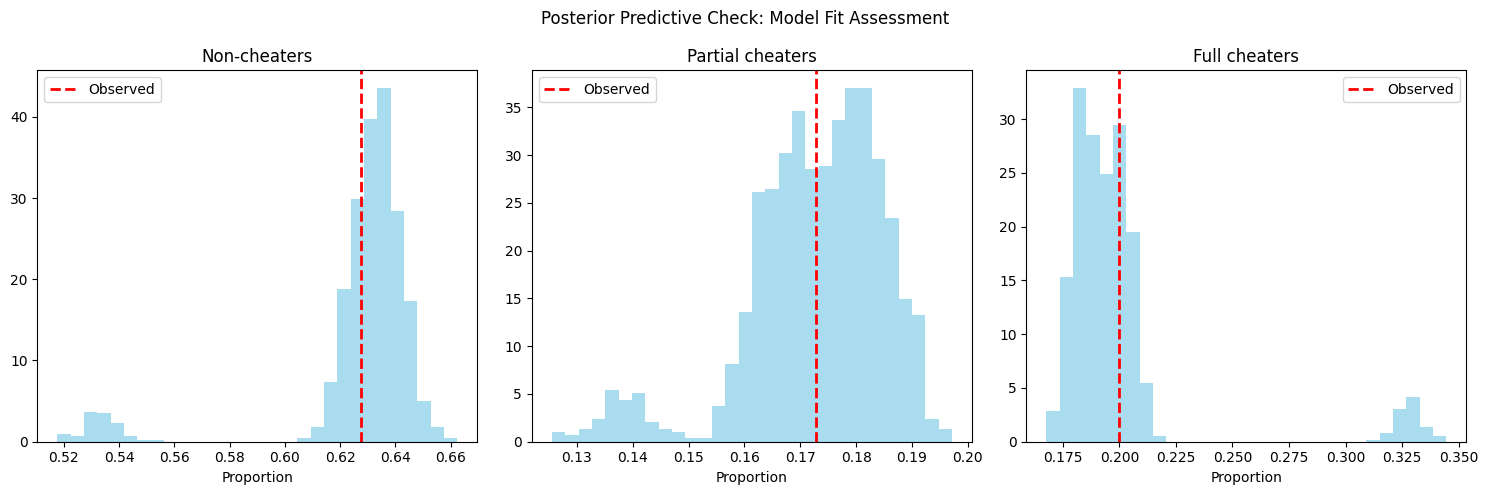

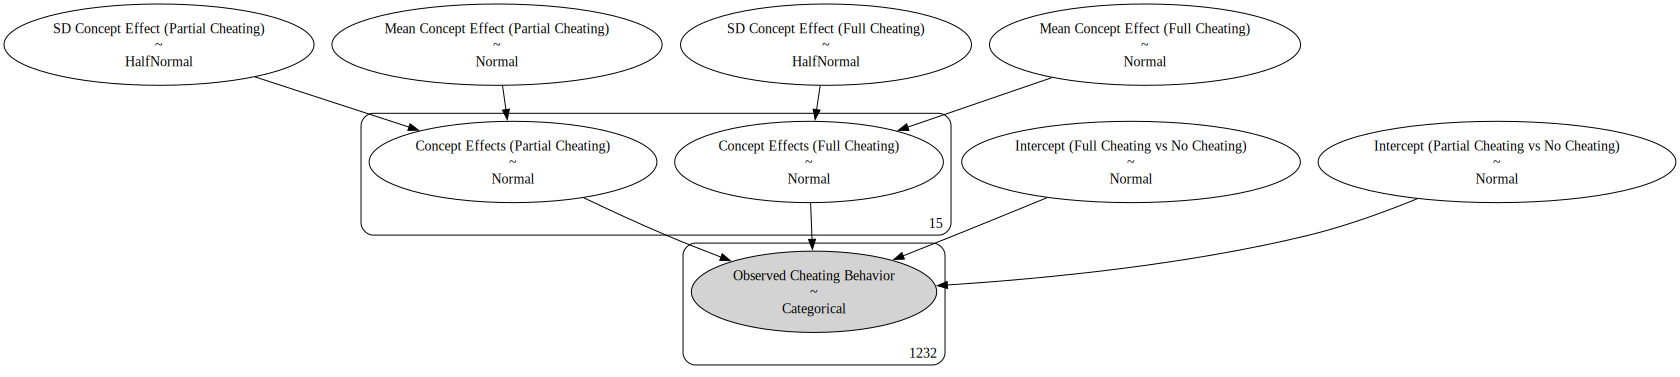

<Axes: xlabel='Observed Cheating Behavior'>

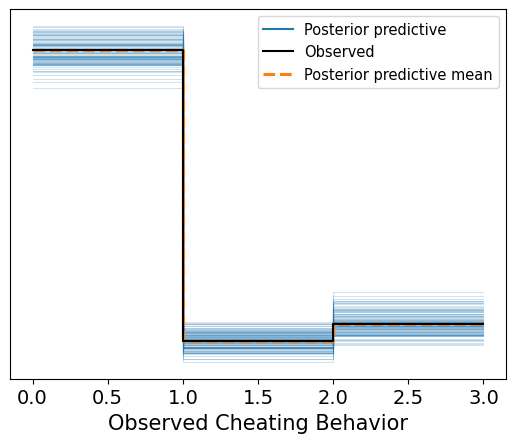

In [8]:
# =============================================================================
# 3.2. MODEL DIAGNOSTICS
# =============================================================================

# Plot diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
y_obs = df['cheating_behavior'].values

for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_obs == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['Observed Cheating Behavior'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Model Fit Assessment')
plt.tight_layout()
plt.show()

display(pm.model_to_graphviz(cheating_model))
display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

In [6]:
# =============================
# 3.3. SUMMARY OF RESULTS (Posteriors)
# =============================

# Calculate predicted probabilities with HDI
beta_partial_samples = trace_cheating.posterior['Intercept (Partial Cheating vs No Cheating)'].values.flatten()
beta_full_samples = trace_cheating.posterior['Intercept (Full Cheating vs No Cheating)'].values.flatten()
partial_effects = trace_cheating.posterior['Concept Effects (Partial Cheating)'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['Concept Effects (Full Cheating)'].values.reshape(-1, len(concepts))

# Control group probabilities
control_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples,
    beta_full_samples
])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# Order concepts by theory
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]
theory_map = {
    'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
    'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
    'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
    'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
    'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
    'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
    'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
}

# Calculate differences for each concept with HDI
results_cheating = []
concept_differences = {}  # Store for reuse in forest plots

for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros(len(beta_partial_samples)),
            beta_partial_samples + partial_effects[:, i],
            beta_full_samples + full_effects[:, i]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        # Differences with HDI
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        partial_diff = (concept_probs[:, 1] - control_probs[:, 1]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        # Store for reuse
        concept_differences[concept] = {
            'non_diff': non_diff,
            'partial_diff': partial_diff,
            'full_diff': full_diff
        }
        
        results_cheating.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': non_diff.mean(),
            'Non_hdi': az.hdi(non_diff, hdi_prob=0.95),
            'Partial_mean': partial_diff.mean(),
            'Partial_hdi': az.hdi(partial_diff, hdi_prob=0.95),
            'Full_mean': full_diff.mean(),
            'Full_hdi': az.hdi(full_diff, hdi_prob=0.95)
        })

df_results = pd.DataFrame(results_cheating)

# Control baseline for labels
control_rates = {
    'Non': control_probs[:, 0].mean() * 100,
    'Partial': control_probs[:, 1].mean() * 100,
    'Full': control_probs[:, 2].mean() * 100
}

# Calculate overall intervention effects for reuse
overall_partial_effects = partial_effects.mean(axis=1)  
overall_full_effects = full_effects.mean(axis=1)

overall_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples + overall_partial_effects,
    beta_full_samples + overall_full_effects
])
overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

overall_results = {}
for i, category in enumerate(['Non', 'Partial', 'Full']):
    diff = (overall_probs[:, i] - control_probs[:, i]) * 100
    overall_results[category] = {
        'mean': diff.mean(),
        'hdi': az.hdi(diff, hdi_prob=0.95)
    }

# Print with HDI
print("Cheating Behavior Changes (percentage points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results.iterrows():
    non_str = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
    partial_str = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
    full_str = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


Cheating Behavior Changes (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +10.5 [+1.7, +20.3]       +4.1 [-3.2, +10.6]        -14.6 [-22.6, -6.3]      
Competence                          Self-Determination Theory      +10.4 [+1.7, +19.9]       +2.8 [-3.9, +9.4]         -13.2 [-21.5, -4.9]      
Relatedness                         Self-Determination Theory      +10.1 [+1.4, +19.3]       +2.6 [-4.1, +9.5]         -12.7 [-20.6, -3.6]      
Self Concept                        Cognitive Dissonance Theory    +10.2 [+1.3, +19.6]       +3.6 [-3.3, +10.3]        -13.8 [-21.7, -5.5]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +10.6 [+1.2, +19.

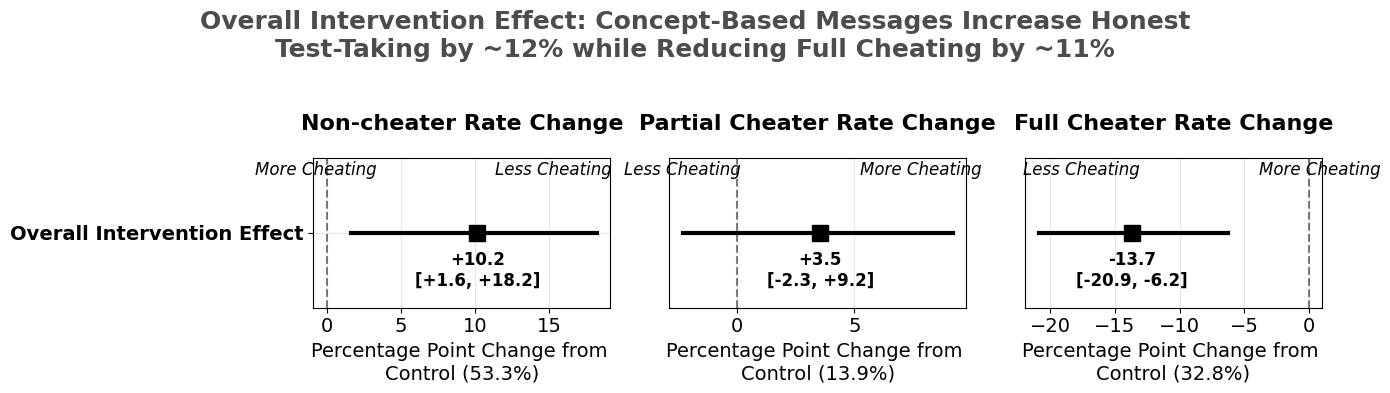

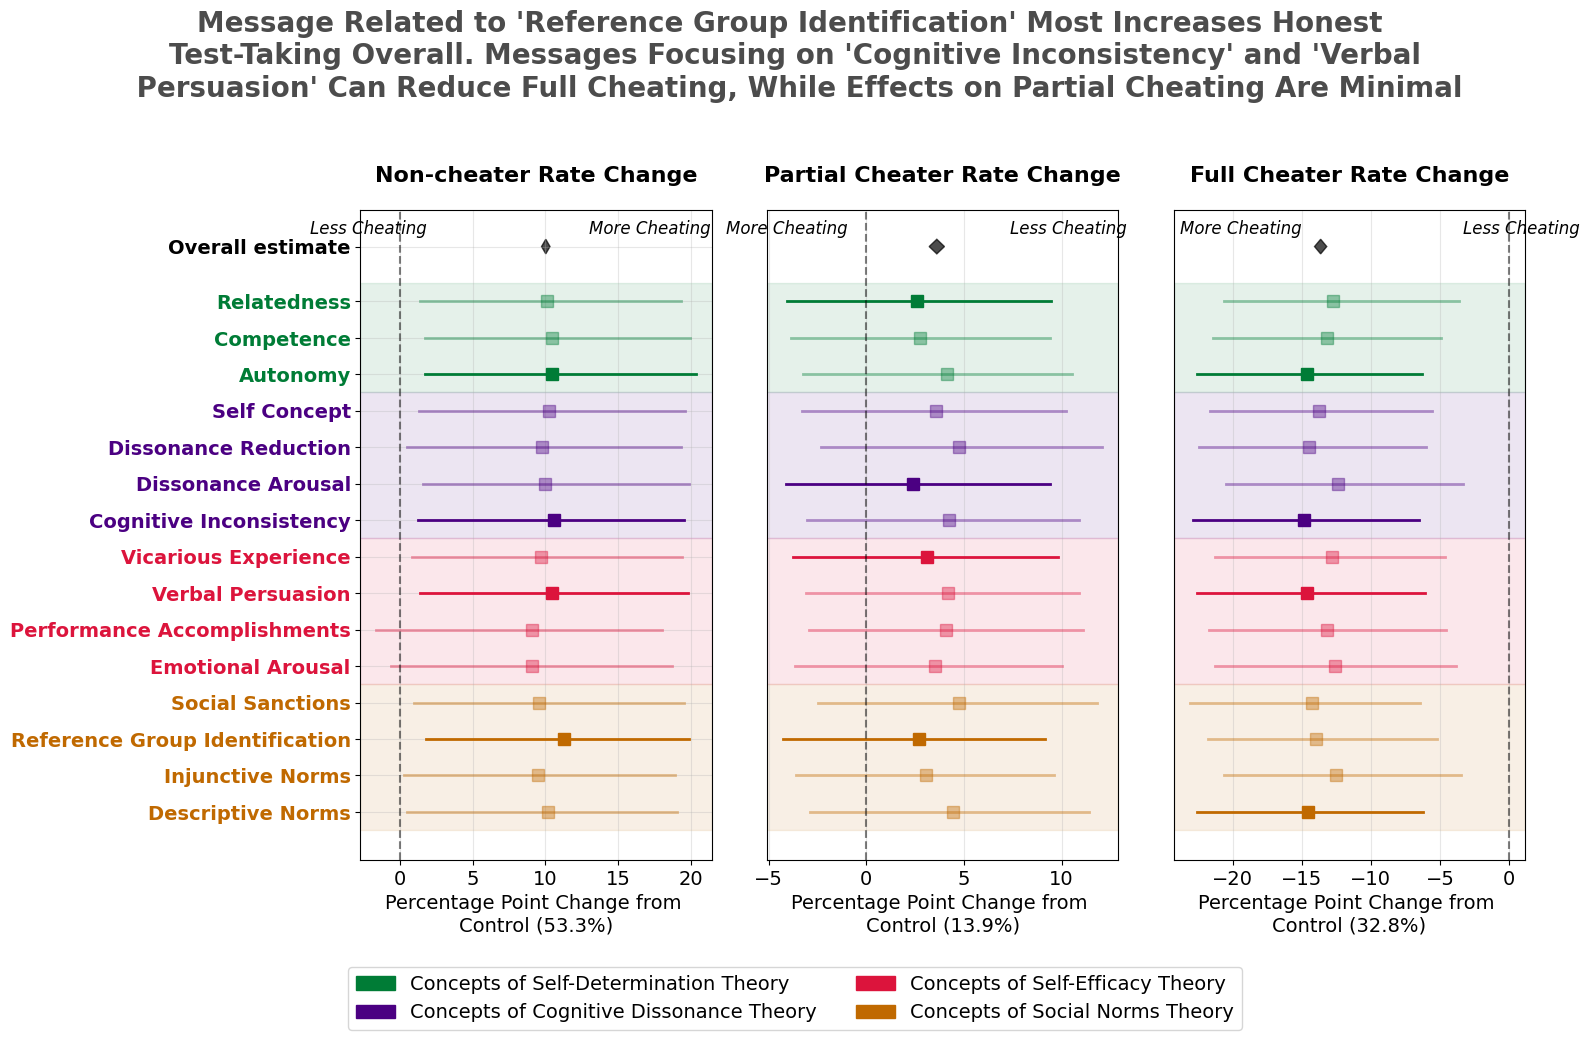

In [7]:
# ===============================================================
# 3.4 FOREST PLOTS FOR CHEATING BEHAVIOR (posterior with 95% HDI)
# ================================================================

categories = ['Non', 'Partial', 'Full']
titles = ['Non-cheater Rate Change', 'Partial Cheater Rate Change', 'Full Cheater Rate Change']

# PLOT 1: Overall intervention effect (reuse overall_results)
fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes1[idx]
    
    mean = overall_results[cat]['mean']
    hdi = overall_results[cat]['hdi']
    
    ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
    ax.plot(mean, 0, 's', color='black', markersize=12)
    
    ax.text(mean, -0.15, f'{mean:+.1f}\n[{hdi[0]:+.1f}, {hdi[1]:+.1f}]', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    if idx == 0:
        ax.set_yticks([0])
        ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
    else:
        ax.set_yticks([])
    
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)
    
    xlim = ax.get_xlim()
    if cat == 'Non':
        ax.text(xlim[0] * 0.8, 0.25, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, 0.25, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
    else:
        ax.text(xlim[0] * 0.8, 0.25, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, 0.25, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')

plt.suptitle('Overall Intervention Effect: Concept-Based Messages Increase Honest\nTest-Taking by ~12% while Reducing Full Cheating by ~11%', 
                fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()

# PLOT 2: By-concept effects (reuse df_results)
import matplotlib.patches as patches

fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))

theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                    'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}

df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
df_results_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes2[idx]
    means = df_results_sorted[f'{cat}_mean'].values
    hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
    
    y_positions = np.arange(len(df_results_sorted))
    
    # Highlight best concept per theory
    highlight_indices = []
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            theory_means = means[indices]
            target_idx = indices[np.argmax(theory_means)] if cat == 'Non' else indices[np.argmin(theory_means)]
            highlight_indices.append(target_idx)
    
    # Background shading and forest plot
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
    
    for i in range(len(df_results_sorted)):
        color = theory_colors[df_results_sorted.iloc[i]['Theory']]
        alpha = 1.0 if i in highlight_indices else 0.4
        ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=alpha, linewidth=2)
        ax.plot(means[i], i, 's', color=color, alpha=alpha, markersize=8)
    
    # Overall estimate diamond
    overall_mean = means.mean()
    overall_se = np.std(means) / np.sqrt(len(means))
    diamond_y = len(df_results_sorted) + 0.5
    diamond_x = [overall_mean - 1.96*overall_se, overall_mean, overall_mean + 1.96*overall_se, overall_mean, overall_mean - 1.96*overall_se]
    diamond_y_coords = [diamond_y, diamond_y + 0.2, diamond_y, diamond_y - 0.2, diamond_y]
    ax.fill(diamond_x, diamond_y_coords, color='black', alpha=0.7)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

    if idx == 0:
        ax.set_yticks(list(y_positions) + [diamond_y])
        y_labels = df_results_sorted['Concept'].tolist() + ['Overall estimate']
        ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

        for tick_label, concept in zip(ax.get_yticklabels()[:-1], df_results_sorted['Concept']):
            theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
            tick_label.set_color(theory_colors[theory])
        ax.get_yticklabels()[-1].set_color('black')
    else:
        ax.set_yticks([])

    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    
    xlim = ax.get_xlim()
    if cat == 'Non':
        ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
    else:
        ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')

legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

plt.suptitle('Message Related to \'Reference Group Identification\' Most Increases Honest \nTest-Taking Overall. Messages Focusing on \'Cognitive Inconsistency\' and \'Verbal\n Persuasion\' Can Reduce Full Cheating, While Effects on Partial Cheating Are Minimal', 
            fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.75, bottom=0.1)
plt.show()
